In [1]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count

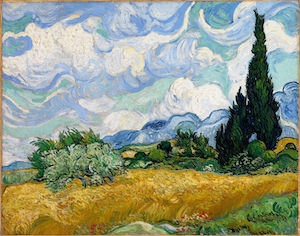

In [2]:
display(REFERENCE_IMAGE)

In [3]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [4]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")

def run_algorithm(settings):
    seed, population_size, crossover_method, num_points, initialization, mutation, selection, generation_budget = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    mutation_method=mutation,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.5,
                    selection_name=selection,
                    verbose=verbose_output)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

## Running a sweep of settings

In [6]:
%%time

generation_budget = 500
 
data = []
for seed in range(1):
    for population_size in (300,):
        for crossover_method in ("UNIFORM", "ONE_POINT", "TWO_POINT", "THREE_POINT"):
            for initialization in ("QUASIRANDOM",):
                for mutation in ("ADD_RANDOM", "SHRINK", ""):
                    for selection in ("tournament_4",):
                        for num_points in (100,):
                            data.extend(run_algorithm((seed, population_size, crossover_method, num_points, initialization, mutation, selection, generation_budget)))

[[  9  19 151 ... 217 117 207]
 [ 34   6 100 ... 147 137 101]
 [ 22  32 253 ...  39 173   5]
 ...
 [ 32  18 224 ...  37 255  21]
 [ 19   5  20 ... 104 144 110]
 [ 44  31 173 ... 103   0 120]] (300, 500)
generation: 1 best fitness: 131972 avg. fitness: 144814.43333333332
generation: 2 best fitness: 130688 avg. fitness: 140007.71666666667
generation: 3 best fitness: 125234 avg. fitness: 136700.47666666665
generation: 4 best fitness: 125234 avg. fitness: 134144.67
generation: 5 best fitness: 123281 avg. fitness: 132371.81666666668
generation: 6 best fitness: 123281 avg. fitness: 130771.73666666666
generation: 7 best fitness: 123183 avg. fitness: 128958.23666666666
generation: 8 best fitness: 120514 avg. fitness: 127369.55666666667
generation: 9 best fitness: 119552 avg. fitness: 125714.35666666667
generation: 10 best fitness: 118181 avg. fitness: 124487.08666666667
generation: 11 best fitness: 118181 avg. fitness: 123405.73
generation: 12 best fitness: 115548 avg. fitness: 122212.52
gener

## Evaluating the results

In [ ]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

   num-generations  num-evaluations  time-elapsed  best-fitness  \
0                1              600           0.0        135883   
1                2              900           1.0        131452   
2                3             1200           1.0        129847   
3                4             1500           2.0        125081   
4                5             1800           2.0        125081   

  crossover-method  population-size  num-points initialization  seed  
0          UNIFORM              300         100            LHS     0  
1          UNIFORM              300         100            LHS     0  
2          UNIFORM              300         100            LHS     0  
3          UNIFORM              300         100            LHS     0  
4          UNIFORM              300         100            LHS     0  


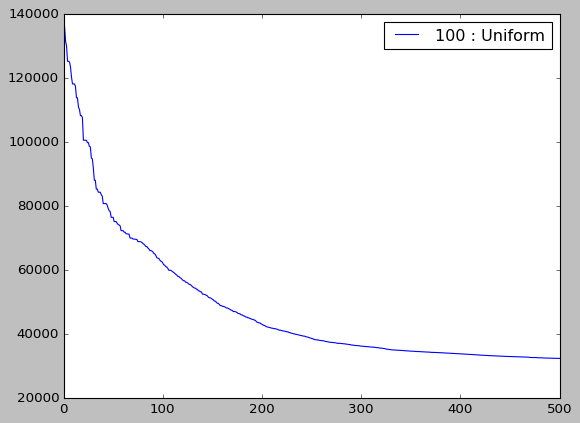

In [ ]:
num_simulations = len(df) // generation_budget

print(df.head())

# Iterate over the simulations and create separate DataFrames
simulations = {}
for i in range(num_simulations):
    start_index = i * 500
    end_index = (i + 1) * 500
    simulations[f"sim{i}"] = df[start_index:end_index]

plot_id = ["100 : Uniform", "100 : OnePoint","100 : TwoPoint", "300 : Uniform", "300 : OnePoint","300 : TwoPoint"]
for simulation_id, simulation_data in simulations.items():
    plt.plot(simulation_data["num-generations"], simulation_data["best-fitness"], label=plot_id[int(simulation_id[3])])
plt.legend()
plt.show()

## Displaying the best instances over time

In [ ]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}.png")) for i in selection]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

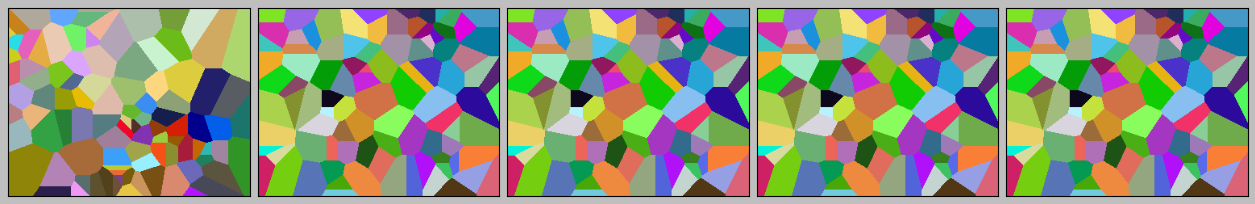

In [ ]:
show_progress_over_time((0, 300, 'UNIFORM', 100, "RANDOM", 500), grid=(1,5))

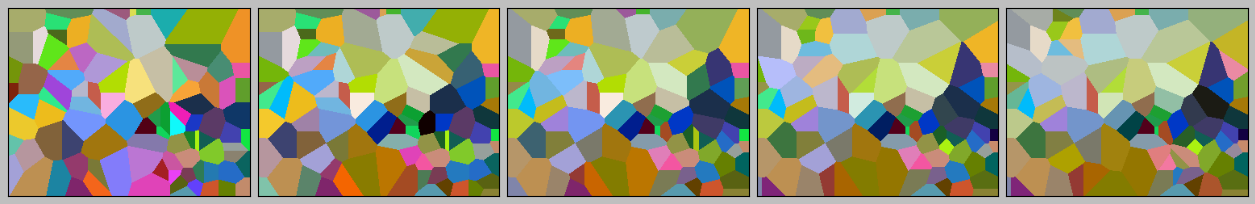

In [ ]:
show_progress_over_time((0, 100, 'ONE_POINT', 100, "RANDOM", 500), grid=(1,5))

In [ ]:
%%time
# data = run_algorithm((0, 100, "UNIFORM", 100, 'RANDOM', 500))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 3.58 µs
